In [1]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn import metrics

from ast import literal_eval

from mlxtend.plotting import plot_decision_regions
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression


import warnings
import numpy as np
from collections import OrderedDict

from lob_data_utils import lob, db_result, model, stocks_numbers
from lob_data_utils.svm_calculation import lob_svm


sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
data_length = 24000
stocks = stocks_numbers.chosen_stocks
should_save_fig = False

In [3]:
d_stocks = {}
d_cv_stocks = {}
d_test_stocks = {}
for s in stocks:
    d,  d_test = lob.load_prepared_data(s, length=data_length)
    d.index = pd.to_datetime(d['Unnamed: 0'].values)
    d_test.index = pd.to_datetime(d_test['Unnamed: 0'].values)
    d['prev_queue_imbalance'] = [None] + d['queue_imbalance'].iloc[0:len(d)-1].values.tolist()
    d.dropna(inplace=True)
    d_test['prev_queue_imbalance'] = [None] + d_test['queue_imbalance'].iloc[0:len(d_test)-1].values.tolist()
    d_test.dropna(inplace=True)
    d_stocks[s] = d
    d_test_stocks[s] = d_test

In [4]:
d_stocks['3459'].head()

,Unnamed: 0,bid,ask,bid_price,ask_price,mid_price,sum_sell_ask,sum_buy_bid,mid_price_indicator,queue_imbalance,prev_queue_imbalance
2013-09-02 08:31:00,2013-09-02 08:31:00,"[(550.0, 4600.0), (590.0, 3500.0), (666.0, 956...","[(749.5, 19522.0), (750.0, 51865.0), (750.5, 1...",748.5,749.5,749.0,19522.0,8078.0,0.0,-0.414638,-0.573878
2013-09-02 08:32:00,2013-09-02 08:32:00,"[(550.0, 4600.0), (590.0, 3500.0), (666.0, 956...","[(749.5, 13371.0), (750.0, 51046.0), (750.5, 1...",748.5,749.5,749.0,13371.0,16818.0,0.0,0.114181,-0.414638
2013-09-02 08:33:00,2013-09-02 08:33:00,"[(550.0, 4600.0), (590.0, 3500.0), (666.0, 956...","[(749.5, 20645.0), (750.0, 51474.0), (750.5, 1...",748.5,749.5,749.0,20645.0,7206.0,0.0,-0.482532,0.114181
2013-09-02 08:34:00,2013-09-02 08:34:00,"[(550.0, 4600.0), (590.0, 3500.0), (666.0, 956...","[(749.5, 14676.0), (750.0, 51474.0), (750.5, 1...",748.5,749.5,749.0,14676.0,7206.0,0.0,-0.341376,-0.482532
2013-09-02 08:35:00,2013-09-02 08:35:00,"[(550.0, 4600.0), (590.0, 3500.0), (666.0, 956...","[(749.0, 9652.0), (749.5, 35846.0), (750.0, 42...",748.0,749.0,748.5,9652.0,5395.0,1.0,-0.282914,-0.341376


## SVM with queue imbalance

In [5]:
df_res = {}
for s in stocks:
#    df_res_temp = pd.read_csv('../svm_queue_imbalance/res_svm/svm_linear_{}_len{}.csv'.format(s, data_length))
#    df_res_temp = df_res_temp.append(pd.read_csv('../svm_queue_imbalance/res_svm/svm_sigmoid_{}_len{}.csv'.format(s, data_length)))
    df_res_temp = pd.read_csv(
        '../svm_queue_imbalance/res_svm/svm_rbf_{}_len{}.csv'.format(s, data_length))
    df_res[s] = df_res_temp
    df_res[s].index = list(range(len(df_res[s])))


In [6]:
df_best_svm = pd.DataFrame()
for s in stocks:
    idx_max = df_res[s]['matthews'].idxmax()
    df_best_svm = df_best_svm.append(df_res[s].loc[idx_max])
df_best_svm

,C,Unnamed: 0,coef0,f1,features,gamma,kappa,kernel,matthews,precision,...,train_matthews,train_precision,train_recall,train_roc_auc,train_val_f1,train_val_kappa,train_val_matthews,train_val_precision,train_val_recall,train_val_roc_auc
23,1.00,23.0,NaN,0.472349,que,0.100,0.101540,rbf,0.103318,0.498954,...,0.085900,0.480375,0.498738,0.543119,0.457277,0.073448,0.073929,0.475918,0.442802,0.536402
35,100.00,35.0,NaN,0.346056,que,0.001,0.092044,rbf,0.121997,0.235344,...,0.129706,0.248281,0.623704,0.581676,0.363850,0.108703,0.135944,0.254718,0.636720,0.584868
9,0.01,9.0,NaN,0.440988,que,0.100,0.110685,rbf,0.124306,0.346020,...,0.119259,0.347967,0.574540,0.565546,0.436963,0.108809,0.120391,0.345596,0.596876,0.565901
12,0.01,12.0,NaN,0.427307,que,100.000,0.146800,rbf,0.155044,0.373604,...,0.126633,0.358512,0.556612,0.569134,0.417938,0.121034,0.130294,0.357596,0.530188,0.568021
38,100.00,38.0,NaN,0.294126,que,1.000,0.111888,rbf,0.147542,0.194451,...,0.145353,0.210925,0.583799,0.600439,0.320966,0.120498,0.153410,0.217568,0.614933,0.604691
28,10.00,28.0,NaN,0.499682,que,0.001,0.058720,rbf,0.058888,0.481040,...,0.062020,0.480170,0.537312,0.531169,0.508247,0.065208,0.065612,0.480650,0.539261,0.532976
40,100.00,40.0,NaN,0.420861,que,100.000,0.112200,rbf,0.125429,0.336286,...,0.126562,0.328360,0.575441,0.571241,0.410046,0.118572,0.127730,0.330979,0.542710,0.571121
30,10.00,30.0,NaN,0.426426,que,0.100,0.129171,rbf,0.142003,0.336219,...,0.123290,0.334475,0.586162,0.568791,0.433357,0.108628,0.122284,0.335616,0.612037,0.567827
43,1000.00,43.0,NaN,0.263692,que,0.010,0.118773,rbf,0.144224,0.251364,...,0.103875,0.191234,0.492023,0.571478,0.253190,0.091697,0.104858,0.188974,0.429891,0.566370
43,1000.00,43.0,NaN,0.448072,que,0.010,0.126557,rbf,0.139459,0.371540,...,0.147411,0.388610,0.544145,0.578951,0.445720,0.140663,0.151609,0.387131,0.554485,0.577872


In [7]:
print(df_best_svm[['stock', 'kernel', 'C', 'gamma', 'coef0']].to_latex())

\begin{tabular}{lrlrrr}
\toprule
{} &    stock & kernel &        C &    gamma &  coef0 \\
\midrule
23 &   9061.0 &    rbf &     1.00 &    0.100 &    NaN \\
35 &   3459.0 &    rbf &   100.00 &    0.001 &    NaN \\
9  &   4549.0 &    rbf &     0.01 &    0.100 &    NaN \\
12 &   9761.0 &    rbf &     0.01 &  100.000 &    NaN \\
38 &   4851.0 &    rbf &   100.00 &    1.000 &    NaN \\
28 &   9062.0 &    rbf &    10.00 &    0.001 &    NaN \\
40 &  11869.0 &    rbf &   100.00 &  100.000 &    NaN \\
30 &  12255.0 &    rbf &    10.00 &    0.100 &    NaN \\
43 &   2748.0 &    rbf &  1000.00 &    0.010 &    NaN \\
43 &   4320.0 &    rbf &  1000.00 &    0.010 &    NaN \\
23 &  11583.0 &    rbf &     1.00 &    0.100 &    NaN \\
25 &   4799.0 &    rbf &     1.00 &   10.000 &    NaN \\
28 &   9268.0 &    rbf &    10.00 &    0.001 &    NaN \\
16 &  10470.0 &    rbf &     0.10 &    0.100 &    NaN \\
42 &   9058.0 &    rbf &  1000.00 &    0.001 &    NaN \\
\bottomrule
\end{tabular}



In [8]:
 from sklearn import utils

def get_classes_weights(y_train):
    classes = np.unique(y_train)
    class_weight_list = utils.class_weight.compute_class_weight('balanced', classes, y_train)
    class_weights = {classes[0]: class_weight_list[0], classes[1]: class_weight_list[1]}
    return class_weights

def fit_best_svm_classifier(df_best_svm, df, stock=None):
    stock = int(stock)
    gamma = df_best_svm[df_best_svm['stock'] == stock]['gamma'].values[0]
    coef0 = df_best_svm[df_best_svm['stock'] == stock]['coef0'].values[0]
    c = df_best_svm[df_best_svm['stock'] == stock]['C'].values[0]
    kernel = df_best_svm[df_best_svm['stock'] == stock]['kernel'].values[0]

    X = df['queue_imbalance'].values.reshape(-1, 1)
    y = df['mid_price_indicator']
   
    weights = get_classes_weights(y)
    clf = SVC(gamma=gamma, C=c, coef0=coef0, kernel=kernel, random_state=23131, class_weight=weights)
    clf.fit(X, y)
    return clf
    

In [9]:
def get_scores_dict_for_data(functions_to_run, dfs, log_clf, stock):
    scores = {'stock': stock}
    for func_name, func in functions_to_run.items():
        for df_name, df in dfs.items():
            pred = log_clf.predict(df['queue_imbalance'].values.reshape(-1, 1))
            df['pred'] = pred
            scores['{}_{}'.format(df_name, func_name)] = func(df['mid_price_indicator'], pred)
    return scores
            
functions_to_run = {'precision': metrics.precision_score, 'roc_auc': metrics.roc_auc_score,
                   'f1_score': metrics.f1_score, 'recall': metrics.recall_score, 
                   'matthews': metrics.matthews_corrcoef, 'kappa': metrics.cohen_kappa_score}
scores = []
for stock in stocks:
    log_clf = fit_best_svm_classifier(df_best_svm, d_stocks[stock], stock=stock)
    dfs = {'train': d_stocks[stock], 'test': d_test_stocks[stock], }
    res_validation = model.validate_model(
        fit_best_svm_classifier(df_best_svm, d_stocks[stock], stock=stock), 
        d_stocks[stock][['queue_imbalance']], d_stocks[stock]['mid_price_indicator'])
    res = get_scores_dict_for_data(functions_to_run, dfs, log_clf, stock)
    res = {**res, **res_validation}
    scores.append(res)
df_scores = pd.DataFrame(scores, index=stocks)

In [10]:
def convert_scores(df, column):
    scores = []
    for i, row in df.iterrows():
        scores.append(np.mean(row[column]))
    return scores
scores_columns = ['f1', 'kappa', 'matthews', 'precision', 'recall', 'roc_auc', 'train_f1', 'train_kappa',
       'train_matthews', 'train_precision', 'train_recall', 'train_roc_auc']

for col in scores_columns:
    df_scores[col] = convert_scores(df_scores, col)
df_scores

,f1,kappa,matthews,precision,recall,roc_auc,stock,test_f1_score,test_kappa,test_matthews,...,train_matthews,train_precision,train_recall,train_roc_auc,train_val_f1,train_val_kappa,train_val_matthews,train_val_precision,train_val_recall,train_val_roc_auc
9061,0.472349,0.101540,0.103318,0.498954,0.458067,0.550456,9061,0.489767,0.093031,0.093155,...,0.085900,0.480375,0.498738,0.543119,"[0.4706038840117052, 0.42621015348288077, 0.44...","[0.06988393711482777, 0.06802447662437316, 0.0...","[0.06988470046291312, 0.06896324503448231, 0.0...","[0.4718591624433182, 0.4742200328407225, 0.477...","[0.46935526664897853, 0.38702760653980167, 0.4...","[0.5349197640750947, 0.5332214524489157, 0.536..."
3459,0.346056,0.092044,0.121997,0.235344,0.658740,0.577255,3459,0.355655,0.112362,0.134119,...,0.129706,0.248281,0.623704,0.581676,"[0.3681575972872598, 0.37060601240655316, 0.36...","[0.11123153964811283, 0.11014490213541817, 0.1...","[0.13980026328240328, 0.13932066642959165, 0.1...","[0.25733634311512416, 0.2586015538290788, 0.25...","[0.6466250709018718, 0.6537598204264871, 0.617...","[0.5870298580593817, 0.5863498799669523, 0.586..."
4549,0.440988,0.110685,0.124306,0.346020,0.614044,0.567872,4549,0.431774,0.122431,0.132924,...,0.119259,0.347967,0.574540,0.565546,"[0.4321115892565663, 0.4303723248314278, 0.426...","[0.10824648945870152, 0.10205806537659579, 0.1...","[0.11719820879578352, 0.11141502471611715, 0.1...","[0.3473282442748092, 0.3430708109371348, 0.349...","[0.5716529250098155, 0.5772709398348408, 0.547...","[0.5643955787237488, 0.5612818626705747, 0.571..."
9761,0.427307,0.146800,0.155044,0.373604,0.521666,0.581671,9761,0.435133,0.104244,0.111120,...,0.126633,0.358512,0.556612,0.569134,"[0.4713876967095851, 0.447856856723194, 0.3924...","[0.09451154861061384, 0.10255392922569206, 0.1...","[0.12136483848321863, 0.12030771209813824, 0.1...","[0.3450261780104712, 0.33885633461305315, 0.35...","[0.7437923250564334, 0.6602362204724409, 0.433...","[0.562599970011322, 0.5656071967358163, 0.5645..."
4851,0.294126,0.111888,0.147542,0.194451,0.615188,0.605738,4851,0.290175,0.109623,0.142386,...,0.145353,0.210925,0.583799,0.600439,"[0.32042862080884893, 0.3298245614035088, 0.32...","[0.09861236009346741, 0.11263685312505878, 0.1...","[0.13340960473703764, 0.1504535864089527, 0.16...","[0.2125171939477304, 0.21978021978021978, 0.22...","[0.6509831460674157, 0.6605762473647224, 0.625...","[0.590249825327914, 0.6017890823238292, 0.6114..."
9062,0.499682,0.058720,0.058888,0.481040,0.520395,0.529561,9062,0.500000,0.043577,0.043992,...,0.062020,0.480170,0.537312,0.531169,"[0.5111459211953248, 0.5096200096200096, 0.501...","[0.07066118448352121, 0.0662540997713329, 0.06...","[0.07109769343621353, 0.0666961614740884, 0.06...","[0.4830334775677522, 0.48060784758448627, 0.47...","[0.5427328556806551, 0.5423598669055542, 0.528...","[0.5357425955795844, 0.5335294560762722, 0.531..."
11869,0.420861,0.112200,0.125429,0.336286,0.585906,0.568426,11869,0.411279,0.095819,0.101515,...,0.126562,0.328360,0.575441,0.571241,"[0.3963035365203484, 0.3935553946415641, 0.401...","[0.1253850383861712, 0.12688125853963372, 0.11...","[0.1309157757867545, 0.13177593713767335, 0.12...","[0.3306642941874259, 0.33140243902439026, 0.33...","[0.49445676274944567, 0.48440285204991085, 0.5...","[0.5728079795200087, 0.5730145721443815, 0.569..."
12255,0.426426,0.129171,0.142003,0.336219,0.587918,0.579604,12255,0.413164,0.099721,0.110026,...,0.123290,0.334475,0.586162,0.568791,"[0.4358176653591235, 0.42294322132097334, 0.41...","[0.08849640952447757, 0.09498850705908646, 0.1...","[0.10305734649456065, 0.1066561382163357, 0.12...","[0.33086876155268025, 0.32786885245901637, 0.3...","[0.6382725832012678, 0.5956752345981232, 0.565...","[0.5564367270142769, 0.5593135497185706, 0.567..."
2748,0.263692,0.118773,0.144224,0.251364,0.439015,0.586850,2748,0.294881,0.104692,0.138332,...,0.103875,0.191234,0.492023,0.571478,"[0.26798265290862866, 0.1973359644795264, 0.22...","[0.04439571204

In [11]:
pivots = []
print('Pivot values')
for i in df_scores.index:
    stock = i
    df = d_stocks[stock]
    
    pivot = np.mean([np.min(df[df['pred'] == 1]['queue_imbalance']), 
                    np.max(df[df['pred'] == 0]['queue_imbalance'])])
    pivots.append(pivot)
df_scores['pivot'] = pivots
df_scores[['pivot', 'stock']]

Pivot values


,pivot,stock
9061,0.111936,9061
3459,0.063351,3459
4549,0.020534,4549
9761,0.071641,9761
4851,0.121941,4851
9062,0.004079,9062
11869,0.038638,11869
12255,0.023962,12255
2748,0.158208,2748
4320,0.130297,4320


In [12]:
df_pivot = df_scores[['pivot', 'stock']]
df_pivot['stock'] = df_pivot['stock'].values.astype(np.int64)

In [13]:
df_log = pd.read_csv('que_log_pivot.csv')
df_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 3 columns):
Unnamed: 0    15 non-null int64
pivot         15 non-null float64
stock         15 non-null int64
dtypes: float64(1), int64(2)
memory usage: 440.0 bytes


In [14]:
df_pivot = pd.merge(df_pivot, df_log[['pivot', 'stock']], 
                    on='stock', suffixes=['', '_log'])

In [15]:
df_pivot.index = df_pivot['stock']
df_pivot.drop(columns=['stock'], inplace=True)
df_pivot

,pivot,pivot_log
stock,,
9061,0.111936,0.023023
3459,0.063351,0.096860
4549,0.020534,0.032053
9761,0.071641,0.043341
4851,0.121941,0.089948
9062,0.004079,0.012105
11869,0.038638,0.037273
12255,0.023962,0.046640
2748,0.158208,0.038263


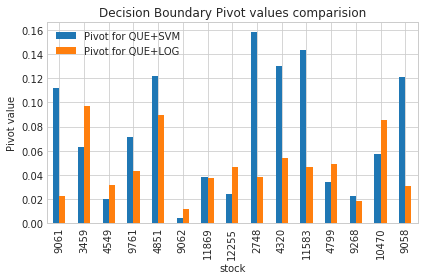

In [16]:
df_pivot.plot(kind='bar')
plt.legend(['Pivot for QUE+SVM', 'Pivot for QUE+LOG'])
plt.title('Decision Boundary Pivot values comparision')
plt.ylabel('Pivot value')
plt.tight_layout()
plt.savefig('que_svm_log_pivot_rbf.png')

In [18]:
df_pivot['stock'] = df_pivot.index
df_pivot[['stock', 'pivot']].to_csv('que_svm_rbf_pivot.csv')